In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers.legacy import Adam

In [20]:
data_folder = ""
processed_data_folder = "{}./processed_data".format(data_folder)
ori_data_folder = "{}./faults/ml_data".format(data_folder)

0.2580101366849613

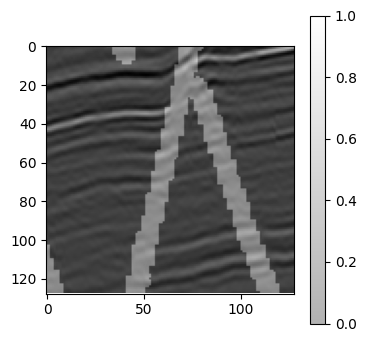

In [21]:
i = 32
seis = np.load("{}/train/seismic/{}.npy".format(processed_data_folder, i))
mask = np.load("{}/train/annotation/{}.npy".format(processed_data_folder, i))
plt.figure(figsize=(4,4))
plt.imshow(seis,"gray")
plt.imshow(mask,"gray",alpha=0.3)
plt.colorbar()
seis.min()

In [7]:
def double_conv_block(x, n_filters,use_dropout):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    if(use_dropout):
        x = layers.Dropout(0.5)(x)
    return x

In [8]:
def block_downsample(x, n_filters,use_dropout):
    f = double_conv_block(x, n_filters,use_dropout)
    p = layers.MaxPool2D(2)(f)
    
    return f, p

In [9]:
def block_upsample(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = double_conv_block(x, n_filters,False)
    return x

In [10]:
#building model
def build_unet_model():
    inputs = layers.Input(shape=(128,128,1))
    # encoder contracting path with downsampling
    f1, p1 = block_downsample(inputs, 64,False)
    f2, p2 = block_downsample(p1, 128,False)
    f3, p3 = block_downsample(p2, 256,False)
    f4, p4 = block_downsample(p3, 512,True)
    # mid bottleneck
    bottleneck = double_conv_block(p4, 1024,True)
    # doing the decoder - and then upsampling
    u6 = block_upsample(bottleneck, f4, 512)
    u7 = block_upsample(u6, f3, 256)
    u8 = block_upsample(u7, f2, 128)
    u9 = block_upsample(u8, f1, 64)
    # the outputs
    u9_1 = layers.Conv2D(2, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(u9)
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9_1)
    # making unet
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [11]:
unet_model = build_unet_model()

Metal device set to: Apple M1 Pro


2023-03-14 14:32:29.973578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-14 14:32:29.973893: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [14]:
x = np.load("./processed_data/train/seismic.npy")
y = np.load('./processed_data/train/annotation.npy')

In [15]:
x.shape

(2894, 128, 128)

In [16]:
y.shape

(2894, 128, 128)

In [17]:
unet_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),loss = tf.keras.losses.BinaryCrossentropy(),metrics =[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()] )

In [35]:
unet_model.fit(x =x , y =y ,batch_size = 10,epochs = 10)

Epoch 1/10


2023-03-13 17:58:51.779322: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-13 17:58:52.813675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


290/290 [==============================] - 95s 321ms/step - loss: 0.3318 - binary_accuracy: 0.8937 - false_negatives: 4619302.0000
Epoch 2/10
290/290 [==============================] - 93s 321ms/step - loss: 0.3207 - binary_accuracy: 0.9016 - false_negatives: 4665905.0000
Epoch 3/10
290/290 [==============================] - 93s 322ms/step - loss: 0.2547 - binary_accuracy: 0.9042 - false_negatives: 4459093.0000
Epoch 4/10
290/290 [==============================] - 94s 323ms/step - loss: 0.1764 - binary_accuracy: 0.9336 - false_negatives: 2302738.0000
Epoch 5/10
290/290 [==============================] - 94s 323ms/step - loss: 0.1257 - binary_accuracy: 0.9493 - false_negatives: 1559952.0000
Epoch 6/10
290/290 [==============================] - 94s 323ms/step - loss: 0.0982 - binary_accuracy: 0.9593 - false_negatives: 1141877.0000
Epoch 7/10
290/290 [==============================] - 93s 322ms/step - loss: 0.0820 - binary_accuracy: 0.9656 - false_negatives: 904405.0000
Epoch 8/10
290/290

In [36]:
x_val = np.load("./processed_data/val/seismic.npy")
y_val = np.load('./processed_data/val/annotation.npy')

In [37]:
x_val[0].shape

(512, 512)

In [5]:
#only works for square matrix
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    if pad_width[1] != 0:           
        vector[-pad_width[1]:] = pad_value
        
def process_image_for_prediction(model,image_train,image_val):
    #process bigger images(x_val dims) for prediction by dividing bigger image into smaller parts(according to x_train dims) and collasing
    #back to original
    
    x_train_dim, y_train_dim = image_train.shape
    x_val_dim, y_val_dim = image_val.shape
    
    print(x_train_dim, x_val_dim, "x_train_dim, x_val_dim")
    
    print(x_val_dim % x_train_dim, "mod")
    if(x_val_dim % x_train_dim):
        # not divisible need to padd with zeros
        no_of_spaces_needed = x_val_dim % x_train_dim
        print(no_of_spaces_needed,'no_of_spaces_needed')
        image_val = np.pad(image_val,((0,1),(0,1)),pad_with,padder = 0) # top =0, down= 1, left =0, right =1 padding
        
        # update the x_val_dim, y_val_dim as it was updated with padding
        x_val_dim, y_val_dim = image_val.shape
        print(x_val_dim, y_val_dim, 'x_val_dim, y_val_dim updated')
    
    
    #iterate all the smaller parts and predict each of them
    no_of_parts = x_val_dim / x_train_dim # since it is square, y will be same
    print(no_of_parts, "no_of_parts")

    predicted_matrix = np.zeros((x_val_dim,y_val_dim,1))

    for i in range(0,int(no_of_parts)):
        for j in range(0,int(no_of_parts)):
            part_image = image_val[i*x_train_dim:(i+1)*x_train_dim,j*y_train_dim:(j+1)*y_train_dim]
            part_image = np.reshape(part_image,(1,part_image.shape[0],part_image.shape[1]))
            print(part_image.shape, 'part_image_shape')
            predicted_matrix[i*x_train_dim:(i+1)*x_train_dim, j*y_train_dim:(j+1)*y_train_dim]  = model.predict(part_image)
            print(predicted_matrix.shape,'predicted_matrix_shape')
    
    return predicted_matrix
                
                
                
    

In [39]:
processed_prediction = process_image_for_prediction(unet_model,x[0],x_val[0])

128 512 x_train_dim, x_val_dim
0 mod
4.0 no_of_parts
(1, 128, 128) part_image_shape


2023-03-13 18:14:42.003356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 407ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128) part_image_shape
1/1 [==============================] - 0s 20ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128) part_image_shape
1/1 [==============================] - 0s 16ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128) part_image_shape
1/1 [==============================] - 0s 16ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128) part_image_shape
1/1 [==============================] - 0s 17ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128) part_image_shape
1/1 [==============================] - 0s 17ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128) part_image_shape
1/1 [==============================] - 0s 16ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128) part_image_shape
1/1 [==============================] - 0s 17ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128) part_image_shape
1/1 [==============================] - 

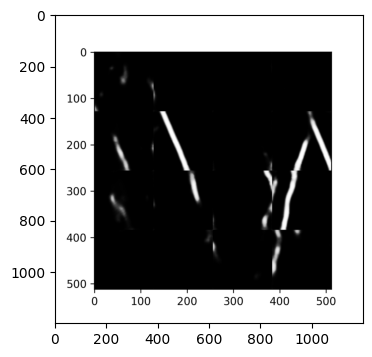

In [21]:
# demonstration of how a 5 min training of model predicts image (the image is saved)
# use the below one for seeing the current prediction image

import matplotlib.image as mpimg
plt.figure(figsize=(4,4))
img = plt.imread("./10epochs.png")
plt.imshow(img,'gray')

In [ ]:
# predicted result plotting

plt.figure(figsize=(4,4))
# plt.imshow(seis,"gray")
# plt.imshow(mask,"gray",alpha=0.3)
plt.imshow(processed_prediction,"gray")
plt.colorbar()

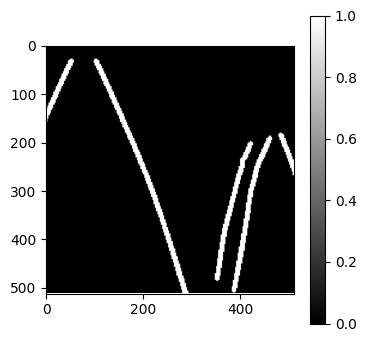

In [41]:
# actual image (the true label)
plt.figure(figsize=(4,4))
# plt.imshow(seis,"gray")
# plt.imshow(mask,"gray",alpha=0.3)
plt.imshow(y_val[0],"gray")
plt.colorbar()

## Post Processing